In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [19]:
cifar_train = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

# cifar_train = torch.randperm(len(cifar_train))[: 5000]
# cifar_test = torch.randperm(len(cifar_train))[: 1000]

Files already downloaded and verified
Files already downloaded and verified


In [20]:
train_size = int(0.8 * len(cifar_train))
val_size = len(cifar_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(cifar_train, [train_size, val_size])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

In [17]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [21]:
def extract_features_labels(dataloader):
    features = []
    labels = []
    for images, lbls in tqdm(dataloader):
        features.append(images.numpy().reshape(len(images), -1))
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

X_train, y_train = extract_features_labels(train_loader)
X_val, y_val = extract_features_labels(val_loader)
X_test, y_test = extract_features_labels(test_loader)

print(f"X_train.shape: {X_train.shape}, y_train_shape: {y_train.shape}")

100%|██████████| 157/157 [00:01<00:00, 84.78it/s]


X_train.shape: (40000, 3072), y_train_shape: (40000,)


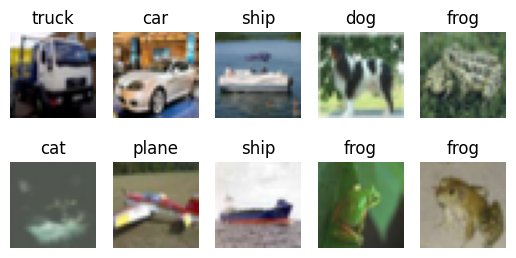

In [7]:
def plot_raw_images(dataset, n=10):

    indices = np.random.choice(len(dataset), n)

    plt.figure()
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()

        plt.subplot(3, n//2, i+1)
        plt.imshow(image)
        plt.title(f"{classes[label]}")
        plt.axis("off")
    plt.show()

plot_raw_images(train_dataset)

In [24]:
X_train, X_test, X_val = X_train[: 4000], X_test[: 1000], X_val[: 1000]
y_train, y_test, y_val = y_train[: 4000], y_test[:1000], y_val[: 1000]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4000, 3072), y_train shape: (4000,)
X_test shape: (1000, 3072), y_test shape: (1000,)
X_val shape: (1000, 3072), y_val shape: (1000,)


In [45]:
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

K=1, Test Accuracy: 0.2710


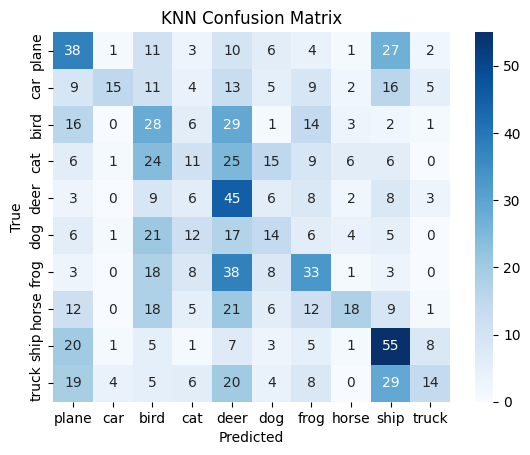

 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

K=3, Test Accuracy: 0.2600


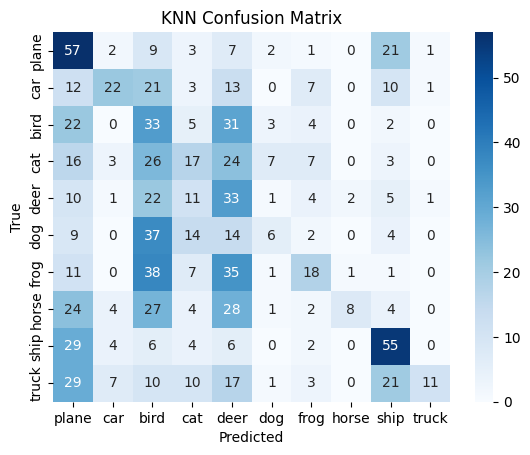

 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

K=5, Test Accuracy: 0.2810


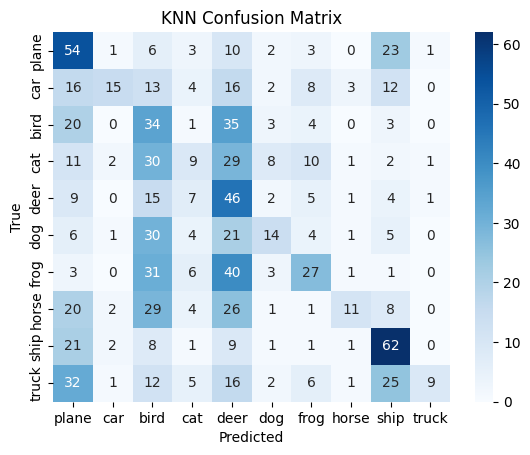

 60%|██████    | 3/5 [00:07<00:04,  2.40s/it]

K=7, Test Accuracy: 0.2750


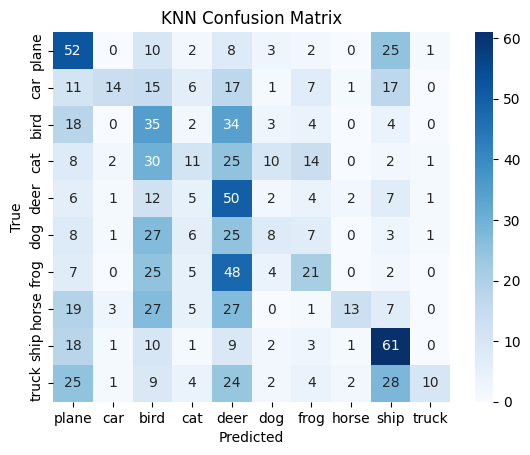

 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

K=9, Test Accuracy: 0.2740


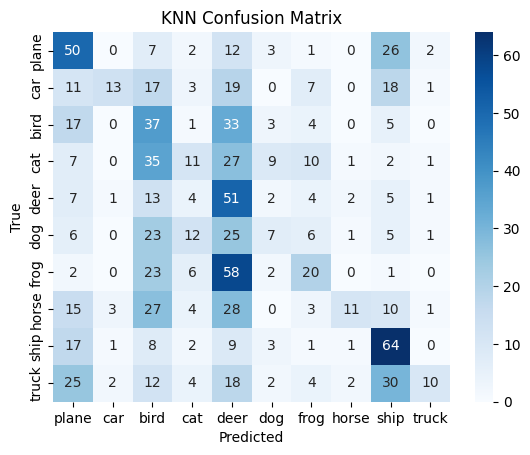

100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


the best k value: K=5, accuracy: 0.2810


In [46]:
k_values = [1, 3, 5, 7, 9]
results = []

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acc = knn.score(X_test, y_test)
    results.append(acc)
    print(f"K={k}, Test Accuracy: {acc:.4f}")

    y_pred_knn = knn.predict(X_test)
    plot_confusion_matrix(y_test, y_pred_knn, classes=classes, title="KNN Confusion Matrix")

best_k = k_values[np.argmax(results)]
print(f"\nthe best k value: K={best_k}, accuracy: {max(results):.4f}")

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

C_values = [0.01, 0.1, 1.0, 10.0]

best_C = None
best_val_acc = 0

for C in tqdm(C_values):
    linear_clf = LogisticRegression(C=C, max_iter=1000)
    linear_clf.fit(X_train, y_train)

    val_acc = linear_clf.score(X_val, y_val)
    print(f"C={C}, Val accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_C = C
        best_val_acc = val_acc

final_linear_clf = LogisticRegression(C=best_C, max_iter=1000)
final_linear_clf.fit(X_train, y_train)


test_acc = final_linear_clf.score(X_test, y_test)
print(f"\nThe best C: C={best_C}")
print(f"Accuracy on test set: {test_acc:.4f}")

 25%|██▌       | 1/4 [00:56<02:50, 56.84s/it]

C=0.01, Val accuracy: 0.3800


 50%|█████     | 2/4 [02:08<02:10, 65.30s/it]

C=0.1, Val accuracy: 0.3440


 75%|███████▌  | 3/4 [04:17<01:34, 94.50s/it]

C=1.0, Val accuracy: 0.3130


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [06:30<00:00, 97.74s/it] 


C=10.0, Val accuracy: 0.2690

The best C: C=0.01
Accuracy on test set: 0.3680


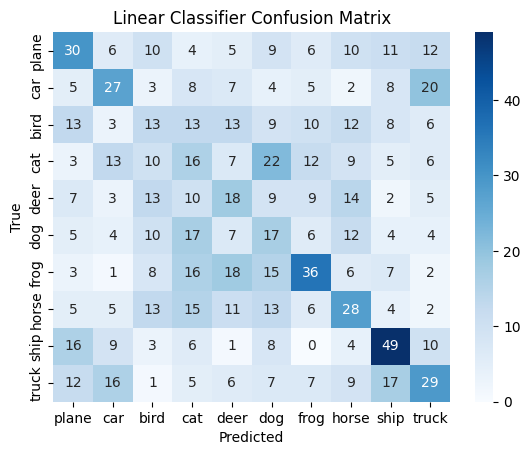

In [47]:
y_pred_linear = linear_clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred_linear, classes=classes, title="Linear Classifier Confusion Matrix")

In [34]:
from sklearn.svm import SVC

C_values = [0.01, 0.1, 1.0, 10.0]

best_C = None
best_val_acc = 0

for C in tqdm(C_values):
    model = SVC(kernel="linear", C=C)
    model.fit(X_train, y_train)

    val_acc = model.score(X_val, y_val)
    print(f"C={C}, Val accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_C = C
        best_val_acc = val_acc
test_acc = model.score(X_test, y_test)

print(f"\nThe best C: C={best_C}")
print(f"\nAccuracy on test set")

 25%|██▌       | 1/4 [00:41<02:05, 41.89s/it]

C=0.01, Val accuracy: 0.3650


 50%|█████     | 2/4 [01:21<01:21, 40.71s/it]

C=0.1, Val accuracy: 0.3410


 75%|███████▌  | 3/4 [02:09<00:43, 43.76s/it]

C=1.0, Val accuracy: 0.3100


100%|██████████| 4/4 [02:57<00:00, 44.49s/it]

C=10.0, Val accuracy: 0.3040



The best C: C=0.01

Accuracy on test set


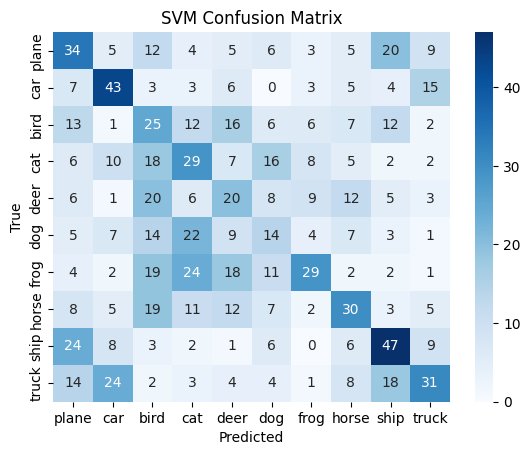

In [48]:
y_pred_svm = svm_clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svm, classes=classes, title="SVM Confusion Matrix")

In [35]:
from skimage.filters import sobel

def extract_edge_features(images):
    edge_features = []
    for img in images:
        img_reshaped = img.reshape(32, 32, 3)
        edge_map = np.zeros_like(img_reshaped)
        for c in range(3):
            edge_map[:, :, c] = sobel(img_reshaped[:, :, c])
        edge_features.append(edge_map.flatten())
    return np.array(edge_features)

X_train_edge = extract_edge_features(X_train)
X_val_edge = extract_edge_features(X_val)
X_test_edge = extract_edge_features(X_test)

def whiten_data(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_whitened = (X - X_mean) / X_std
    return X_whitened

X_train_whitened = whiten_data(X_train)
X_val_whitened = whiten_data(X_val)
X_test_whitened = whiten_data(X_test)

from sklearn.preprocessing import normalize

def l2_normalize(X):
    return normalize(X, norm='l2')

X_train_l2 = l2_normalize(X_train)
X_val_l2 = l2_normalize(X_val)
X_test_l2 = l2_normalize(X_test)

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_knn(X_train, y_train, X_val, y_val, X_test, y_test, k=3):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    test_acc = knn.score(X_test, y_test)
    return test_acc

test_acc_raw = evaluate_knn(X_train, y_train, X_val, y_val, X_test, y_test)

test_acc_edge = evaluate_knn(X_train_edge, y_train, X_val_edge, y_val, X_test_edge, y_test)

test_acc_whitened = evaluate_knn(X_train_whitened, y_train, X_val_whitened, y_val, X_test_whitened, y_test)

test_acc_l2 = evaluate_knn(X_train_l2, y_train, X_val_l2, y_val, X_test_l2, y_test)

print(f"raw accuracy: {test_acc_raw:.4f}")
print(f"edge map accuracy: {test_acc_edge:.4f}")
print(f"whitening accuracy: {test_acc_whitened:.4f}")
print(f"L2-normalization accuracy: {test_acc_l2:.4f}")

raw accuracy: 0.2600
edge map accuracy: 0.2330
whitening accuracy: 0.2610
L2-normalization accuracy: 0.2690


In [39]:
from sklearn.linear_model import LogisticRegression

def evaluate_linear(X_train, y_train, X_val, y_val, X_test, y_test):
    linear_clf = LogisticRegression(max_iter=1000)
    linear_clf.fit(X_train, y_train)
    val_acc = linear_clf.score(X_val, y_val)
    test_acc = linear_clf.score(X_test, y_test)
    return val_acc, test_acc

val_acc_raw, test_acc_raw = evaluate_linear(X_train, y_train, X_val, y_val, X_test, y_test)

val_acc_edge, test_acc_edge = evaluate_linear(X_train_edge, y_train, X_val_edge, y_val, X_test_edge, y_test)

val_acc_whitened, test_acc_whitened = evaluate_linear(X_train_whitened, y_train, X_val_whitened, y_val, X_test_whitened, y_test)

val_acc_l2, test_acc_l2 = evaluate_linear(X_train_l2, y_train, X_val_l2, y_val, X_test_l2, y_test)

print(f"raw accuracy: {test_acc_raw:.4f}")
print(f"edge map accuracy: {test_acc_edge:.4f}")
print(f"whitening accuracy: {test_acc_whitened:.4f}")
print(f"L2-normalization accuracy: {test_acc_l2:.4f}")

raw accuracy: 0.2890
edge map accuracy: 0.2870
whitening accuracy: 0.2670
L2-normalization accuracy: 0.3540


In [40]:
from sklearn.svm import SVC

def evaluate_svm(X_train, y_train, X_val, y_val, X_test, y_test):
    svm_clf = SVC(kernel="linear")
    svm_clf.fit(X_train, y_train)
    val_acc = svm_clf.score(X_val, y_val)
    test_acc = svm_clf.score(X_test, y_test)
    return val_acc, test_acc

val_acc_raw, test_acc_raw = evaluate_svm(X_train, y_train, X_val, y_val, X_test, y_test)

val_acc_edge, test_acc_edge = evaluate_svm(X_train_edge, y_train, X_val_edge, y_val, X_test_edge, y_test)

val_acc_whitened, test_acc_whitened = evaluate_svm(X_train_whitened, y_train, X_val_whitened, y_val, X_test_whitened, y_test)

val_acc_l2, test_acc_l2 = evaluate_svm(X_train_l2, y_train, X_val_l2, y_val, X_test_l2, y_test)

print(f"raw accuracy: {test_acc_raw:.4f}")
print(f"edge map accuracy: {test_acc_edge:.4f}")
print(f"whitening accuracy: {test_acc_whitened:.4f}")
print(f"L2-normalization accuracy: {test_acc_l2:.4f}")

raw accuracy: 0.3020
edge map accuracy: 0.2730
whitening accuracy: 0.2950
L2-normalization accuracy: 0.3570
